In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from persiantext import PersianText

In [2]:
def convert_persian_digits_to_latin(s):
    digits = {'۰':'0', '۱':'1', '۲':'2', '۳':'3', '۴':'4', '۵':'5', '۶':'6', '۷':'7', '۸':'8', '۹':'9'}
    if type(s) == str:
        for pd in digits.keys():
            s = s.replace(pd, digits[pd])
    return s

def reshape_axes_labels(ax):
    xt = ax.get_xticklabels()
    for t in xt:
        t.set_text(PersianText.reshape(t.get_text()))
    ax.set_xticklabels(xt)
#     yt = ax.get_yticklabels()
#     print(yt)
#     for t in yt:
#         if len(t.get_text()) > 0:
#             t.set_text(PersianText.reshape(t.get_text()))
#     ax.set_yticklabels(yt)
    return


In [3]:
df = pd.read_json('tehran--real-estate.json')

# Preparing data

In [4]:
#df.isnull().sum()
del df['تلفن']
del df['تور مجازی ۳۶۰ درجه']
del df['کد ملی صاحب آگهی']
del df['قیمت']
del df['اجاره روزانه']
del df['مایل به معاوضه']
del df['سند اداری']
del df['بالکن']
del df['آژانس املاک']
del df['قیمت کل']
del df['اجاره']
del df['ودیعه']
del df['طبقه']


In [5]:
#df.isnull().sum()
df.columns = ['post_id', 'get_date', 'post_date', 'main_category', 'sub_category',
              'category', 'location', 'area', 'build_year', 'rooms', 'advertiser',
              'ad_type', 'elevator', 'parking', 'depot', 'suitable_for']


In [6]:
df['area'] = df['area'].apply(lambda x: convert_persian_digits_to_latin(x))
df['area'] = df['area'].apply(lambda x: x.replace(' متر', '') if type(x) == str else x)
df['area'] = df['area'].apply(lambda x: x.replace('٫', '') if type(x) == str else x)
df['area'] = df['area'].str.strip().astype('float').astype('Int16')

BASE_YEAR = 1399
df['build_year'] = df['build_year'].apply(lambda x: convert_persian_digits_to_latin(x))
df['build_year'] = df['build_year'].apply(lambda x: x.replace('قبل از ', '') if type(x) == str else x)
df['build_year'] = df['build_year'].str.strip().astype('float').astype('Int16')
df['age'] = BASE_YEAR - df['build_year']

CITY_NAME = 'تهران، '
df['location'] = df['location'].apply(lambda x: x.replace(CITY_NAME, '') if type(x) == str else x)

df['ad_type'] = df['ad_type'].apply(lambda x: x.replace('ارائه', 'اجاره') if type(x) == str else x)

rooms = {'بدون اتاق':'0',
         'یک':'1',
         'دو':'2',
         'سه':'3',
         'چهار':'4',
         'پنج یا بیشتر':'5'}
for r in rooms.keys():
    df['rooms'] = df['rooms'].apply(lambda x: x.replace(r, rooms[r]) if type(x) == str else x)
df['rooms'] = df['rooms'].str.strip().astype('float').astype('Int16')

In [57]:
df2 = df[['location', 'sub_category', 'ad_type', 'age', 'rooms', 'area', 'parking']].copy()
df2['parking'].fillna('نامعلوم', inplace=True)
df2 = df2.dropna()
df2 = df2[df2['area'] <= 2000]
# df2['parking'].value_counts()

# Manipulating and visualizing data

In [8]:
COL_NAMES = ['ad_type', 'sub_category', 'location']
gr = df.groupby(by=COL_NAMES).agg(['count', 'mean'])
# gr = df.groupby(by=COL_NAMES).count()[['post_id']]
# gr = gr.reset_index()
# gr.columns = [COL_NAME, 'count']
# gr.sort_values(by=['count'], ascending=False)
gr.unstack().unstack().T.reset_index()
# gr

ad_type,level_0,level_1,location,sub_category,اجاره,فروشی
0,build_year,count,آبشار,آپارتمان,1.000000,1.000000
1,build_year,count,آبشار,خانه و ویلا,NaN,1.000000
2,build_year,count,آبشار,دفتر کار، اتاق اداری و مطب,NaN,NaN
3,build_year,count,آبشار,صنعتی، کشاورزی و تجاری,0.000000,1.000000
4,build_year,count,آبشار,مغازه و غرفه,NaN,NaN
...,...,...,...,...,...,...
7411,age,mean,یوسف‌آباد,خانه و ویلا,NaN,1.000000
7412,age,mean,یوسف‌آباد,دفتر کار، اتاق اداری و مطب,15.333333,14.666667
7413,age,mean,یوسف‌آباد,صنعتی، کشاورزی و تجاری,NaN,NaN
7414,age,mean,یوسف‌آباد,مغازه و غرفه,19.000000,NaN


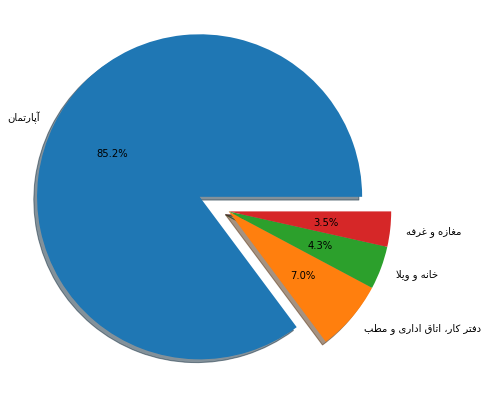

In [55]:
aggregate = df2.groupby(by=['sub_category']).count()['age'].nlargest(4)
labels = list(aggregate.index)
labels = [PersianText.reshape(s) for s in labels]
explode = (0.2, 0, 0, 0)

# plt.figure(figsize=(8, 8))
fig1, ax1 = plt.subplots()
fig1.set_size_inches(7, 7)
ax1.pie(aggregate, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

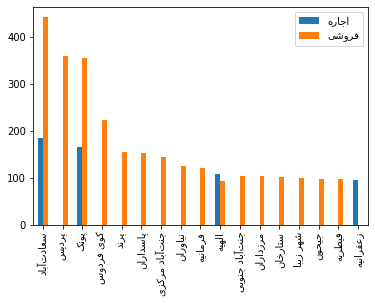

In [100]:
SUB_CAT = 'آپارتمان'
aggregate = df2[df2['sub_category'] == SUB_CAT].groupby(by=['location', 'ad_type']).count()['age'].nlargest(20)
aggregate = aggregate.unstack()
aggregate.index = [PersianText.reshape(s) for s in list(aggregate.index)]
aggregate.columns = [PersianText.reshape(s) for s in list(aggregate.columns)]
aggregate.plot(kind='bar')
plt.show()


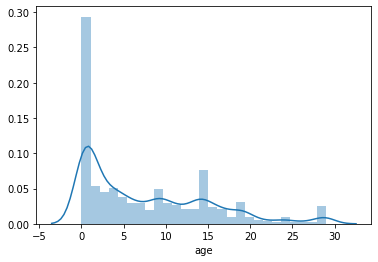

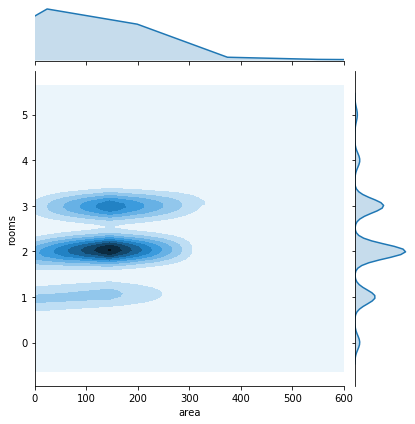

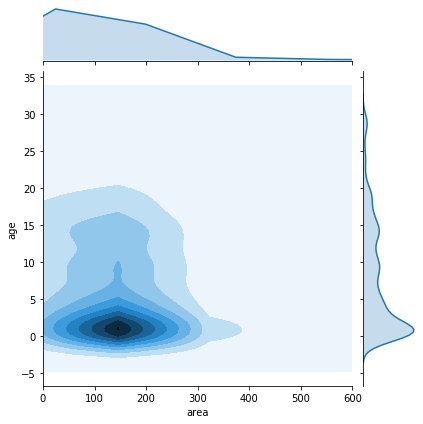

In [34]:
sns.distplot(df2['age'])
sns.jointplot(x='area', y='rooms', data=df2, xlim=(0, 600), kind='kde')
sns.jointplot(x='area', y='age', data=df2, xlim=(0, 600), kind='kde')
plt.show()

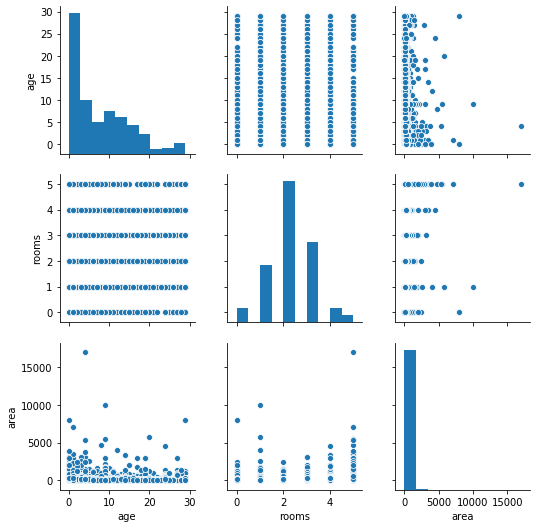

In [45]:
sns.pairplot(data=df2, kind='scatter') # x_vars=['area'], y_vars=['age', 'rooms'])
plt.show()

In [47]:
sns.set(style='whitegrid', color_codes=True)
np.random.seed(sum(map(ord, 'categorical')))

# Note: below code is very time consuming

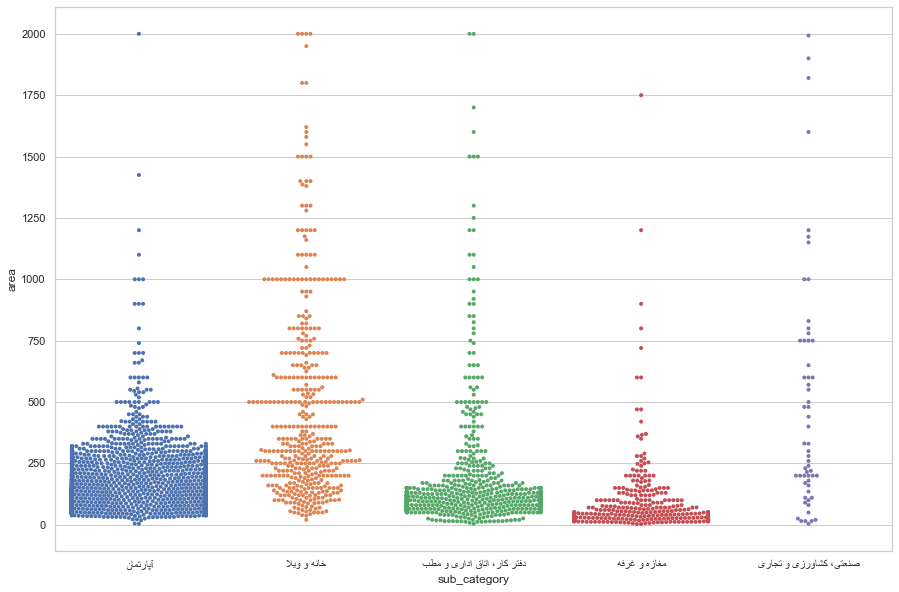

In [94]:
plt.subplots(figsize=(15, 10))
# ax = sns.stripplot(x='sub_category', y='area', data=df2, size=4, jitter=True)
ax = sns.swarmplot(x='sub_category', y='area', data=df2, size=4)
reshape_axes_labels(ax)
plt.show()


# Note: below code is very time consuming

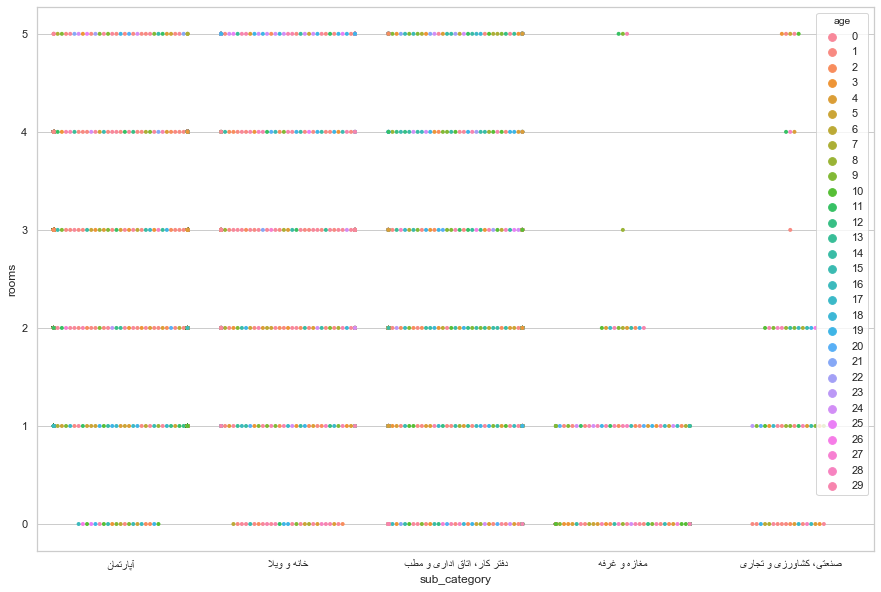

In [95]:
plt.subplots(figsize=(15, 10))
ax = sns.swarmplot(x='sub_category', y='rooms', data=df2, size=4, hue='age')
reshape_axes_labels(ax)
plt.show()


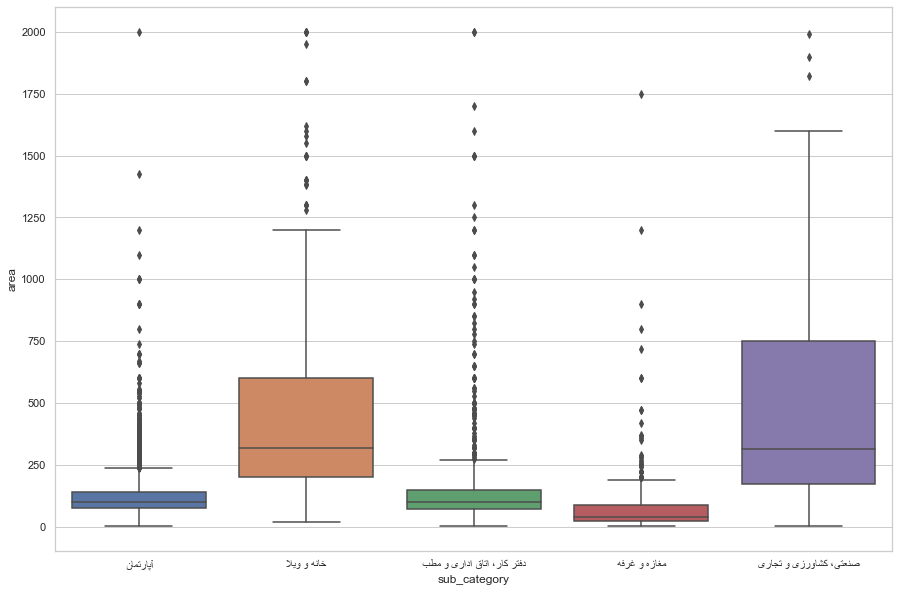

In [104]:
plt.subplots(figsize=(15, 10))
# ax = sns.boxplot(x='sub_category', y='rooms', data=df2)
# ax = sns.boxplot(x='sub_category', y='age', data=df2)
ax = sns.boxplot(x='sub_category', y='area', data=df2)
reshape_axes_labels(ax)
plt.show()

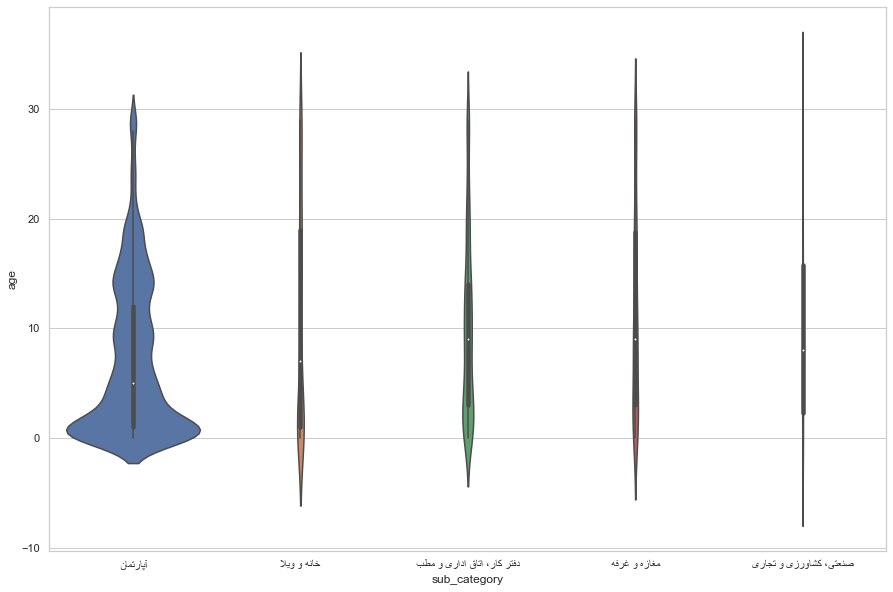

In [109]:
df3 = df2.copy()
df3['age'] = df3['age'].astype('float')
plt.subplots(figsize=(15, 10))
# ax = sns.violinplot(x='sub_category', y='age', data=df3)
ax = sns.violinplot(x='sub_category', y='age', data=df3, scale='count')
reshape_axes_labels(ax)
plt.show()

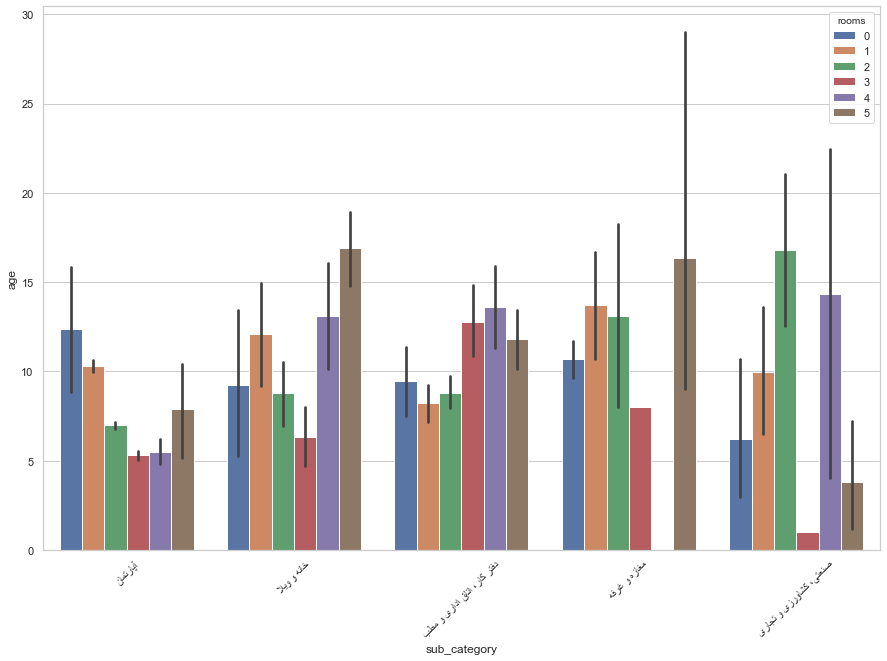

In [113]:
plt.subplots(figsize=(15, 10))
ax = sns.barplot(x='sub_category', y='age', data=df2, hue='rooms')
plt.xticks(rotation=45)
reshape_axes_labels(ax)
plt.show()

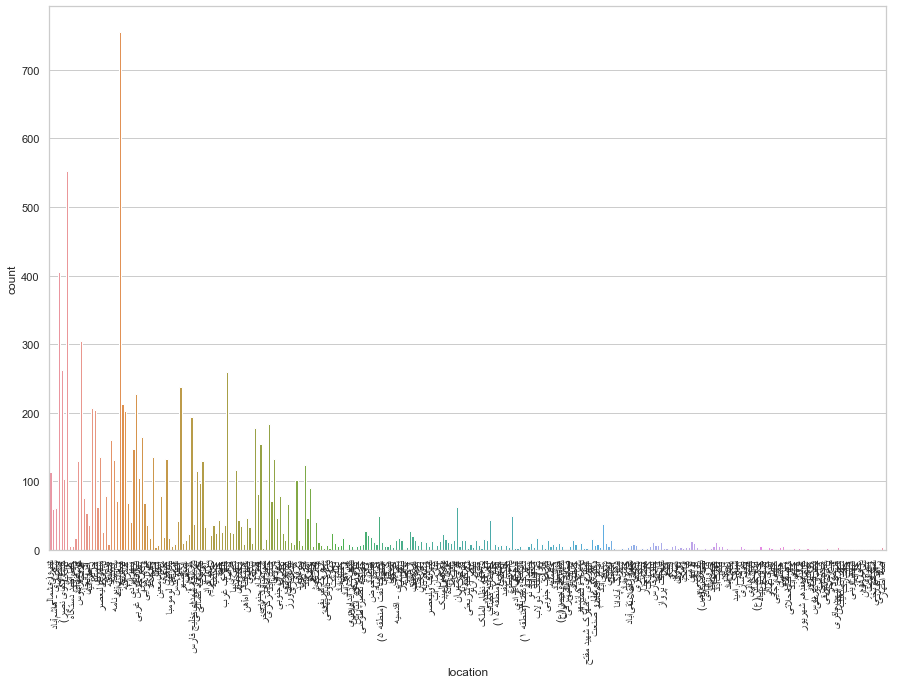

In [116]:
plt.subplots(figsize=(15, 10))
# ax = sns.countplot(x='rooms', data=df2)
ax = sns.countplot(x='location', data=df2)
plt.xticks(rotation=90)
reshape_axes_labels(ax)
plt.show()

/home/rasoul/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


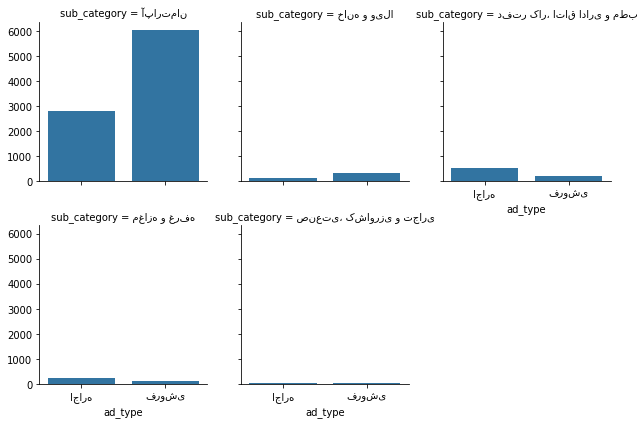

In [39]:
# g = sns.FacetGrid(data=df2, col='sub_category')
# g.map(plt.hist, 'age')

# g = sns.FacetGrid(data=df2, col='sub_category', hue='age')
# g.map(plt.scatter, 'rooms', 'area')
# g.add_legend()

g = sns.FacetGrid(data=df2, col='sub_category', col_wrap=3)
g.map(sns.countplot, 'ad_type')

plt.show()

/home/rasoul/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


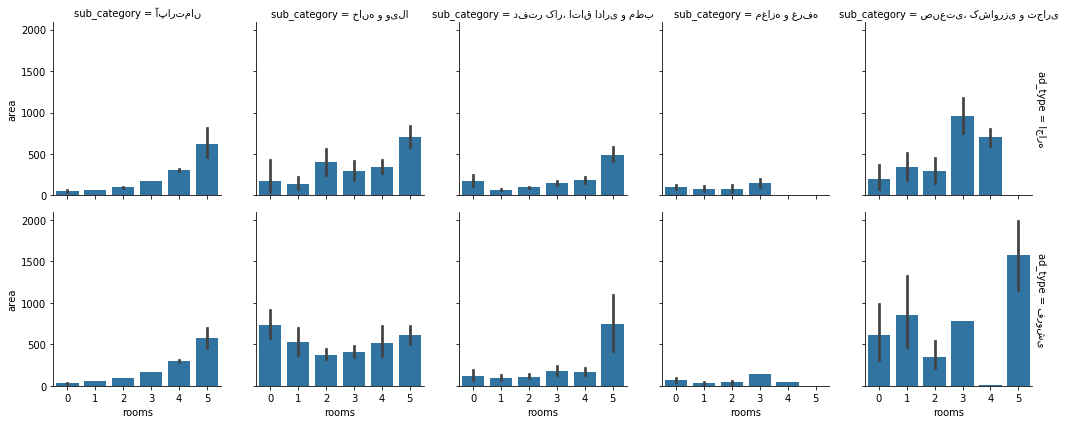

In [59]:
g = sns.FacetGrid(data=df2, row='ad_type', col='sub_category', margin_titles=True)
g.map(sns.barplot, 'rooms', 'area')
# g.map(plt.hist, 'area')
g.add_legend()
plt.show()

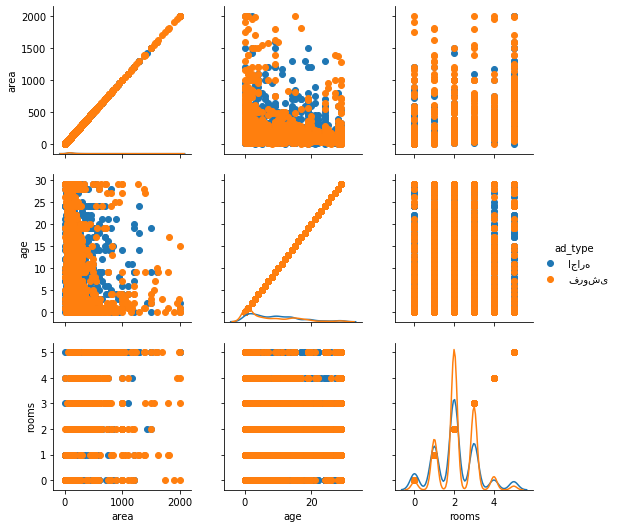

In [61]:
g = sns.PairGrid(data=df2, vars=['area', 'age', 'rooms'], hue='ad_type')
g.map(plt.scatter)
g.map_diag(sns.kdeplot)
g.add_legend()
plt.show()